In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'] = 'Nimbus Sans'
plt.rcParams['font.size'] = 9

In [120]:
# LOAD BOMBUS VISIT DATA WITH INTERVALS AND SPECIES ID, LIMIT TO CLOVER PERIOD
df = pd.read_csv('csvs/bombus_visit_durations.csv', parse_dates=["visit_start", "visit_end"])
bombus_visits_clover = df[df['visit_end'] < pd.Timestamp('2024-07-30')]

In [121]:
# PIVOT TO WIDE FORMAT OF COUNTS PER COLOR, COLS ARE COLORS
species_col_visits = pd.DataFrame(bombus_visits_clover[bombus_visits_clover['species'] != 'unk'].groupby(['species', 'color']).size()).reset_index()

species_col_visits.columns = ['species', 'color', 'visit_count']
species_col_wide = species_col_visits.pivot_table(
    index='species',
    columns='color',
    values='visit_count',
    fill_value=0
)

order = ['appositus', 'mixtus', 'nevadensis', 'griseocollis', 'fervidus', 'vosnesenskii']
# color_order = ['cnt', 'blv', 'grn', 'blu', 'yel']
color_order = ['yel','blu', 'grn','blv','cnt']
species_col_wide = species_col_wide[color_order]
species_col_wide = species_col_wide.reindex(order)

In [122]:
species_col_wide

color,yel,blu,grn,blv,cnt
species,,,,,
appositus,0.0,0.0,0.0,1.0,0.0
mixtus,0.0,0.0,0.0,0.0,1.0
nevadensis,0.0,0.0,0.0,1.0,1.0
griseocollis,0.0,3.0,0.0,3.0,7.0
fervidus,9.0,6.0,19.0,5.0,31.0
vosnesenskii,20.0,20.0,43.0,40.0,50.0


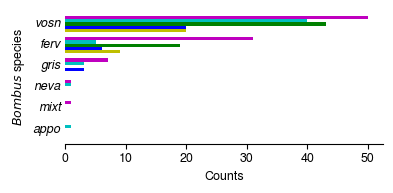

In [123]:
# PLOT SPECIES COUNTS PER STIMULUS TYPE
colors = species_col_wide.columns
species = ['appo', 'mixt', 'neva', 'gris', 'ferv', 'vosn']

color_map = {
    'blu': 'b',
    'blv': 'c',
    'cnt': 'm',
    'grn': 'g',
    'yel': 'y'
}

x = np.arange(len(species))
width = 0.15 

fig, ax = plt.subplots(figsize=(4, 2))
for i, color in enumerate(colors):
    ax.barh(x + i * width, species_col_wide[color], width, color=color_map[color])

ax.set_xlabel('Counts')
ax.set_ylabel(r'$\it{Bombus}$ species')

ax.set_yticks(x + width * len(colors) / 2)
ax.set_yticklabels(species)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='both', length=0)
ax.set_yticklabels([f"{label}" for label in species], style='italic')

plt.tight_layout()
plt.savefig('figs/stimulus_species_counts_smaller.svg', format='svg')

In [124]:
# LOAD SPECIES COUNTS FOR CAMERA TRAPS, BLUE VANE TRAPS, AND HAND NETTING
cam_bombus_counts = bombus_visits_clover['species'].value_counts()

survey_data = pd.read_csv('csvs/Clover_Bee_occurrence_data.csv')
bvt_data  = survey_data[survey_data['Collection method'] == 'vane trap'].reset_index(drop=True)
net_data  = survey_data[survey_data['Collection method'] == 'net'].reset_index(drop=True)

bvt_taxa = bvt_data[['Order ', 'Genus', 'Species', 'Sex', 'Caste']]
bvt_bombus_counts = bvt_taxa[bvt_taxa['Genus'] == 'Bombus']['Species'].value_counts()

net_taxa = net_data[['Order ', 'Genus', 'Species', 'Sex', 'Caste']]
net_bombus_counts = net_taxa[net_taxa['Genus'] == 'Bombus']['Species'].value_counts()

species_all = list(set(cam_bombus_counts.index).union(bvt_bombus_counts.index, net_bombus_counts.index))

species_all = [
 'caliginosus',
 'mixtus',
 'appositus',
 'nevadensis',
 'griseocollis',
 'fervidus',
 'vosnesenskii']

counts_s1 = [cam_bombus_counts[species] if species in cam_bombus_counts.index else 0 for species in species_all]
counts_s2 = [bvt_bombus_counts[species] if species in bvt_bombus_counts.index else 0 for species in species_all]
counts_s3 = [net_bombus_counts[species] if species in net_bombus_counts.index else 0 for species in species_all]

df_counts = pd.DataFrame({
    'Species': species_all,
    'Camera': counts_s1,
    'BVT': counts_s2,
    'Net': counts_s3
})

# df_counts.to_csv('method_comparison_fig/sample_method_counts.csv', index=False)

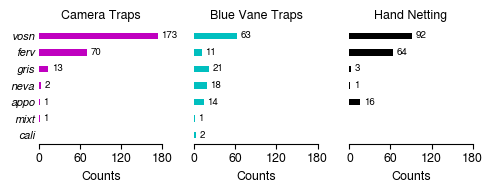

In [125]:
# PLOT METHODS COMPARISON
bar_width = 0.4  
species_all_reversed = list(reversed(species_all))
y_pos = range(len(species_all_reversed))  

fig, axs = plt.subplots(1, 3, figsize=(5, 2), sharey=True)

axs[0].set_yticks(y_pos)
axs[0].invert_yaxis()
axs[0].set_xlabel('Counts', size=9)
axs[0].set_title('Camera Traps', size=9)
bars0 = axs[0].barh(y_pos, list(reversed(counts_s1)), height=bar_width, color='m')
for bar, count in zip(bars0, list(reversed(counts_s1))):
    if count != 0:
        axs[0].text(
            bar.get_width() + 5,
            bar.get_y() + bar.get_height()/2,
            str(count),
            va='center',
            ha='left',
            size=7
        )

bars1 = axs[1].barh(y_pos, list(reversed(counts_s2)), height=bar_width, color='c')
for bar, count in zip(bars1, list(reversed(counts_s2))):
    if count != 0:
        axs[1].text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[1].set_yticks(y_pos)
axs[1].set_yticklabels([])  
axs[1].invert_yaxis()
axs[1].set_xlabel('Counts', size=9)
axs[1].set_title('Blue Vane Traps', size=9)

bars2 = axs[2].barh(y_pos, list(reversed(counts_s3)), height=bar_width, color='k')
for bar, count in zip(bars2, list(reversed(counts_s3))):
    if count != 0:
        axs[2].text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, str(count),
                    va='center', ha='left', size=7)
axs[2].set_yticks(y_pos)
axs[2].set_yticklabels([]) 
axs[2].invert_yaxis()
axs[2].set_xlabel('Counts', size=9)
axs[2].set_title('Hand Netting', size=9)

for ax in axs:
    ax.spines['left'].set_visible(False)
    ax.tick_params(axis='y', length=0)
    ax.set_xlim(0, 180)
    ax.set_xticks(range(0, 181, 60))


axs[0].set_yticklabels(
    [label[:4] for label in species_all_reversed],
    style='italic',
    size=8
)
plt.tight_layout()
plt.savefig('figs/methods_comparison_separated.svg', format='svg')

In [126]:
# EXPORT ABUNDANCE COUNTS FOR iNEXT
cam_bombus_counts = cam_bombus_counts.to_frame()
cam_abund = cam_bombus_counts.sum(axis=1).to_dict()
cam_abund.pop('unk')
bvt_bombus_counts = bvt_bombus_counts.to_frame()
bvt_abund = bvt_bombus_counts.sum(axis=1).to_dict()
net_bombus_counts = net_bombus_counts.to_frame()
net_abund = net_bombus_counts.sum(axis=1).to_dict()

abundance_list = {
    "camera": cam_abund,
    "bvt": bvt_abund,
    "net": net_abund
}


import json

all_species = set()
for method_data in abundance_list.values():
    all_species.update(method_data.keys())
all_species = sorted(all_species)

inext_ready = {
    method: [method_data.get(species, 0) for species in all_species]
    for method, method_data in abundance_list.items()
}

with open("csvs/abundance_list.json", "w") as f:
    json.dump(inext_ready, f)